First, let's connect Python with MySQL so we can run SQL queries from the Python kernel. I find this a lot easier than dealing with Pandas' querying approach.

In [18]:
#instantiate mysql connection and cursor
import mysql.connector
cnx = mysql.connector.connect(user='root', 
                              password='icing46_tarots', 
                              host = '127.0.0.1', 
                              database='EVENTBRITEHW')

Cool, if the above cell didn't throw any errors we're all connected and set up to start analysis. It's useful to import every tool you're going to use on the offset. I like to use Pandas, Matplotlib, and the styling library Seaborn.

In [19]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

Usually I'll start out by checking that all of the data's loaded correctly. For brevity's sake I'll leave that step out.

Now, I have a few questions and things I'd like to explore that came up while I was looking at the data. The ones included in this notebook are bolded.

**Trends:**
- **Number of paid events**
- Mean ticket price
- Mean tickets sold per event
- Mean tickets sold overall
- **Paid events per category**

**Opportunities:**
- **Which events are typically paid versus unpaid?**
- Which countries have the most and fewest organizers?
- Who are our most active organizers? How do they typically behave?

So, with those questions as a guideline, let's set up some visualizations.

In [20]:
#create query and execute into a pandas dataframe
event_query = ('''SELECT 
                    event_publish_date,
                    is_listed,
                    event_paid_type,
                    event_category,
                    COUNT(DISTINCT(e.event_id)) AS events                  
                FROM events AS e
                LEFT JOIN orders AS o ON e.event_id = o.event_id
                GROUP BY e.event_id, 
                    event_publish_date, 
                    is_listed, 
                    event_paid_type, 
                    event_category
                ''')
df = pd.read_sql_query(event_query, cnx)


In [108]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


So let's check out an easy trend to map first. This code and following graph shows the trend for events stacked by paid versus unpaid, cohorted by publish date. The first graph is a 7-day rolling average of paid and free events per day; the second shows the same trend, smoothed over as a 28-day rolling average. It looks like trends for both paid and free events are going in the right direction! 

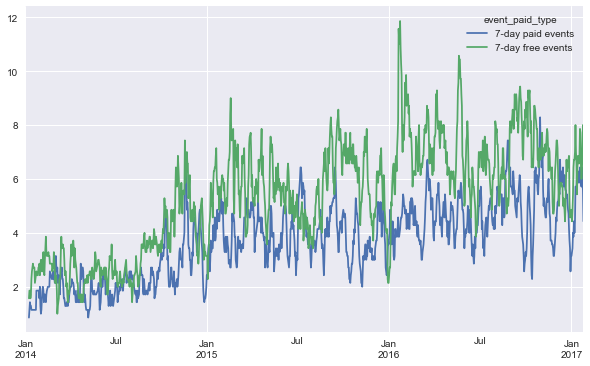

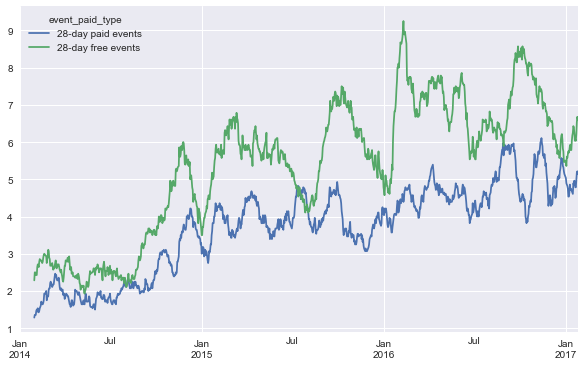

In [109]:
#Gives us an easy-to-use table
plot_df = df.groupby(['event_publish_date', 'event_paid_type'])['events'].sum()
plot_df = plot_df.unstack('event_paid_type', fill_value = 0)
plot_df.index = pd.PeriodIndex(plot_df.index.tolist(), freq='D')

#creates a 7-day rolling average of paid and free events
plot_df['7-day paid events'] = plot_df['paid event'].rolling(window=7, center=False).mean()
plot_df['7-day free events'] = plot_df['free event'].rolling(window=7, center=False).mean()

plot_df['28-day paid events'] = plot_df['paid event'].rolling(window=28, center=False).mean()
plot_df['28-day free events'] = plot_df['free event'].rolling(window=28, center=False).mean()
#plot it ouuuut
plot_df[['7-day paid events', '7-day free events']].plot()
plot_df[['28-day paid events', '28-day free events']].plot()


Let's do the same thing, but instead look at the event categories. 

In [23]:
import numpy as np
#Gives us an easy-to-use table
df2 = df.groupby(['event_publish_date', 'event_paid_type', 'event_category'])['events'].sum()
df2 = df2.unstack('event_paid_type', fill_value = 0)
df2 = df2.unstack('event_category', fill_value = 0)
df2.index = pd.PeriodIndex(plot_df.index.tolist(), freq='D')

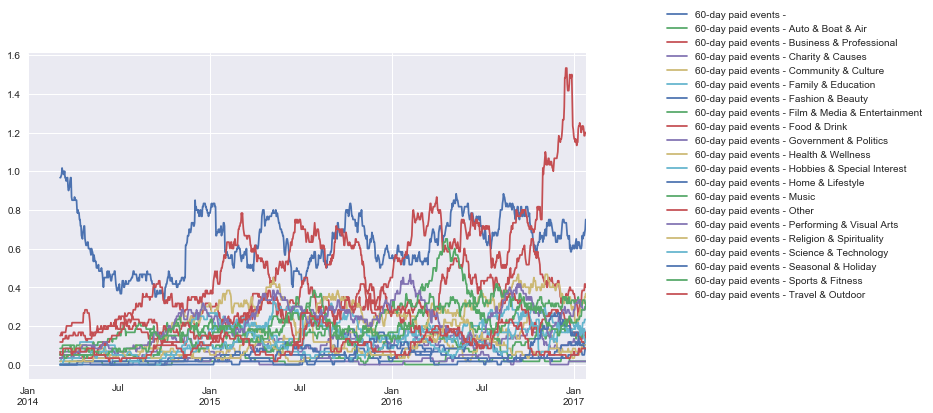

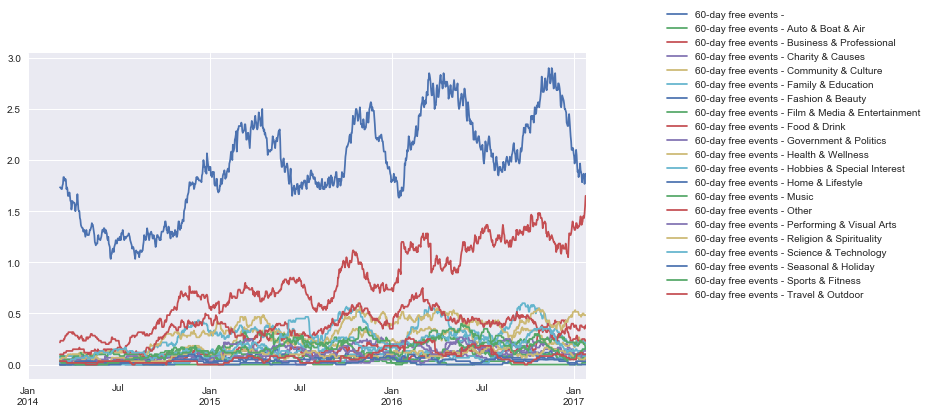

In [115]:
#loop through event categories , make columns for 28-day rolling means
for c in df2.columns:
    if c[0] == "":
        s = "60-day events - %s" %c[1]
        df2[c[0],s] = df2[c].rolling(window=60, center=False).mean()
    else: 
        s = "60-day " + c[0] +"s - %s" %c[1]
        df2["60-day %s" % c[0], s] = df2[c].rolling(window=60, center=False).mean()
df2.columns.tolist()



#plot paid in one graph, unpaid in the other

df2['60-day paid event'].plot(label = '60-Day Paid events')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
df2['60-day free event'].plot(label = "60-Day Free events")
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.show()


So that's a lot of lines and it's hard to get any meaningful signal out of the noise. Sometimes it's best to pull separate plots for a few things at a time. I'll just look at the total number of events per category to decide what is most important.

In [111]:
colList =['Auto & Boat & Air',
 'Business & Professional',
 'Charity & Causes',
 'Community & Culture',
 'Family & Education',
 'Fashion & Beauty',
 'Film & Media & Entertainment',
 'Food & Drink',
 'Government & Politics',
 'Health & Wellness',
 'Hobbies & Special Interest',
 'Home & Lifestyle',
 'Music',
 'Other',
 'Performing & Visual Arts',
 'Religion & Spirituality',
 'Science & Technology',
 'Seasonal & Holiday',
 'Sports & Fitness',
 'Travel & Outdoor']
newColList = []
numList = []
valsList = []
paidList = []
freeList = []
for item in colList:
    valsList.append(df2[''][item].sum() + df2['paid event'][item].sum() + df2['free event'][item].sum())
    newColList.append(item)
    paidList.append(df2['paid event'][item].sum())
    freeList.append(df2['free event'][item].sum())


ndf = pd.DataFrame({'Category': newColList, "Paid":paidList, "Free":freeList})
ndf.set_index('Category')
ndf.sort_values(["Paid"], ascending=False).head(n=5)


,Category,Free,Paid
1,Business & Professional,894,620
7,Food & Drink,150,336
9,Health & Wellness,361,281
12,Music,191,276
14,Performing & Visual Arts,139,250


In [112]:
ndf.sort_values(["Free"], ascending=False).head(n=5)

,Category,Free,Paid
1,Business & Professional,894,620
13,Other,386,223
9,Health & Wellness,361,281
4,Family & Education,309,170
3,Community & Culture,227,112


It looks like there's some difference between the 5 most popular categories for free and paid events. Let's graph them over time to see if there's a trend.

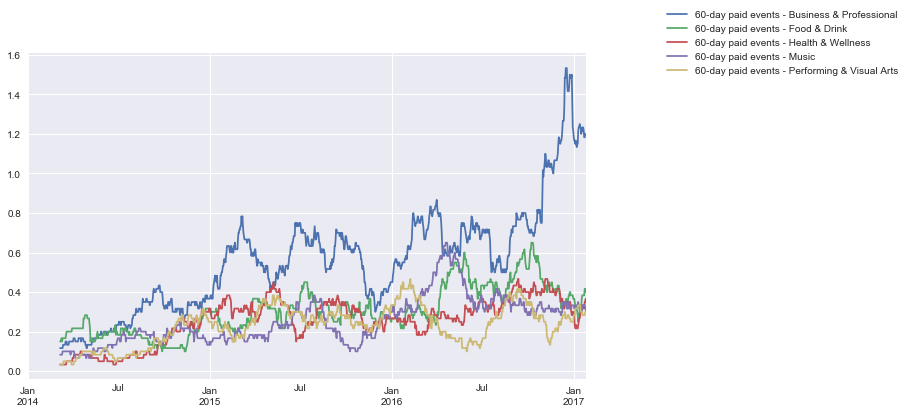

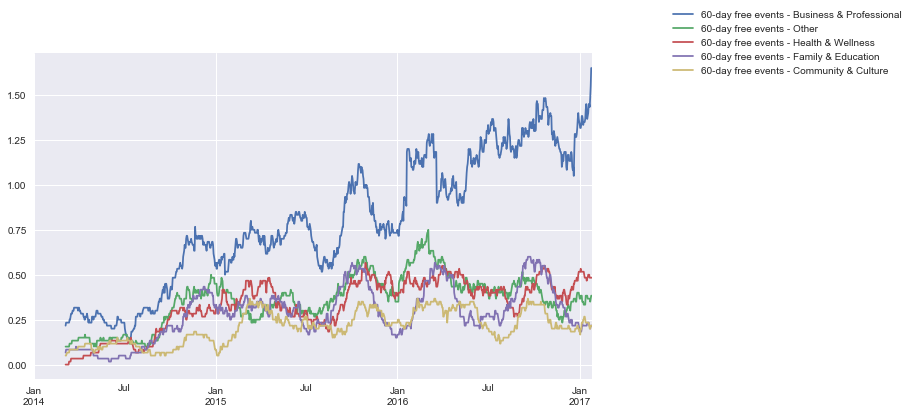

In [116]:
paidList = ['60-day paid events - Business & Professional', 
            '60-day paid events - Food & Drink',
            '60-day paid events - Health & Wellness',
            '60-day paid events - Music',
            '60-day paid events - Performing & Visual Arts']
freeList = ['60-day free events - Business & Professional', 
            '60-day free events - Other',
            '60-day free events - Health & Wellness',
            '60-day free events - Family & Education',
            '60-day free events - Community & Culture']
df2['60-day paid event'][paidList].plot(label = '28-Day Paid events')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
df2['60-day free event'][freeList].plot(label = '28-Day Free events')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)

It appears that, while people are definitely willing to pay for events in both the Business & Professional and Health & Wellness categories, the number free events for both categories is larger than that in paid events- and the growth in free business and professional events is consistently higher despite the peaks in the paid events. This shows a clear opportunity to encourage customers to monetize their events in those categories.